https://www.kaggle.com/code/piyas0/image-captioning-with-transformers

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
# from torchvision.datasets.mnist import MNIST
from keras.datasets import mnist
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import os
import pandas as pd
from torchvision import datasets, transforms
import shutil
import cv2
from PIL import Image  # Import PIL for conversion
import wandb

2025-04-11 17:00:50.803449: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 17:00:50.930506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744390851.097256      21 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744390851.144463      21 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-11 17:00:51.483616: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appro

In [2]:
torch.cuda.is_available()

True

In [3]:
device = "cuda"

In [4]:
image_caption_data =  pd.read_parquet("/shared-volume/UNATA STORAGE/docker_shared_files/data_root_own_laptop/data/image_text_datasets/google_conceptual_captions/image_caption_data_first_7000_cleaned.parquet")

In [5]:
image_caption_data["caption"] = "[START] "+ image_caption_data["caption"].str.lower().str.replace('[^\w\s]','') + " [END]"

In [6]:
image_path = "/shared-volume/UNATA STORAGE/docker_shared_files/data_root_own_laptop/data/image_text_datasets/google_conceptual_captions/images"

In [7]:
# image_caption_data[((image_caption_data["is_image_available"]==True)&(image_caption_data["valid_img_flag"]==False))]

In [ ]:
(image_caption_data['caption'].str.split().apply(lambda x: len(x)) < 20).sum()

<Axes: >

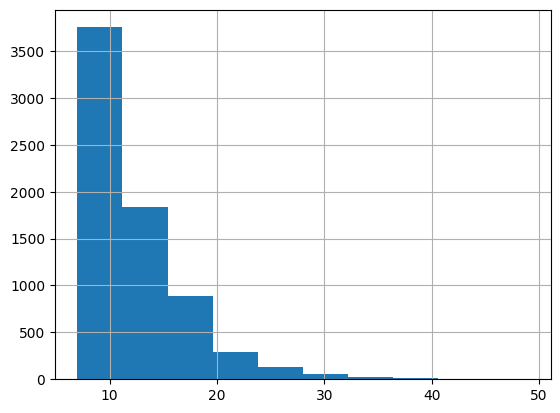

In [13]:
image_caption_data['caption'].str.split().apply(lambda x: len(x)).hist()

In [9]:
image_caption_data['caption'].str.split().explode().value_counts()

caption
[START]       7000
[END]         7000
the           4440
a             3479
.             2881
              ... 
earring          1
caricature       1
sweets           1
spikes           1
approached       1
Name: count, Length: 7204, dtype: int64

In [14]:
image_caption_data_train_val = image_caption_data[image_caption_data.valid_img_flag]

In [15]:
image_caption_data_train_val.shape # image_caption_data_pred.shape

(4706, 4)

In [16]:
(image_caption_data_train_val['caption'].str.split().apply(lambda x: len(x)) < 20).sum()

4310

In [17]:
# image_caption_data_train_val = image_caption_data_train_val[image_caption_data_train_val['caption'].str.split().apply(lambda x: len(x)) < 20]

In [18]:
image_caption_data_train_val = image_caption_data_train_val.drop(["is_image_available","valid_img_flag"], axis=1)
# image_caption_data_pred = image_caption_data_pred.drop("is_image_available", axis=1)

In [19]:
image_caption_data_train_val

img_index                                            caption
0             0  [START] christmas tree on a black background ....
1             1  [START] item : drawing of a figure surrounded ...
2             2  [START] the sidewalk near the corner of street...
4             4  [START] another possible invitation -- love th...
6             6  [START] using shrubs and hedges as fences is a...
...         ...                                                ...
6994       6994  [START] conceptual cartoon about no smoking si...
6995       6995  [START] garment - i ask deity for a true frien...
6996       6996    [START] marble statue of - 1st century ce [END]
6997       6997  [START] illustration of a letter m is for mamm...
6998       6998  [START] person , wood and glass characterize a...

[4310 rows x 2 columns]

In [20]:
image_caption_data_train_val = image_caption_data_train_val.reset_index(drop=True)

In [21]:
train_index = image_caption_data_train_val.sample(int(len(image_caption_data_train_val)*0.90)).index.tolist()

In [22]:
train_set = image_caption_data_train_val.loc[train_index]
val_set = image_caption_data_train_val.loc[[i for i in image_caption_data_train_val.index if i not in train_index]]

In [23]:
train_set.shape, val_set.shape

((3879, 2), (431, 2))

In [24]:
len(set(train_set.caption.str.split().explode().tolist()))

5222

In [25]:
from tokenizers import BertWordPieceTokenizer, Tokenizer

# Initialize an empty BERT tokenizer
tokenizer = BertWordPieceTokenizer(
    unk_token="[UNK]",
    clean_text=False,
    lowercase=True,
)

tokenizer.train_from_iterator(
    train_set["caption"].tolist(),
    vocab_size=4600,
    special_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
)

In [26]:
t = tokenizer.encode(train_set["caption"].iloc[3])

In [27]:
t.ids, t.tokens

([2, 614, 1974, 4063, 2701, 119, 108, 2775, 3],
 ['[START]',
  'small',
  'pine',
  '##apple',
  'growing',
  'in',
  'the',
  'region',
  '[END]'])

In [28]:
tokenizer.decode(t.ids)

'small pineapple growing in the region'

In [29]:
vocab = tokenizer.get_vocab

In [30]:
del image_caption_data
del image_caption_data_train_val

In [31]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_32_Weights # requires torchvision >= 0.13, "DEFAULT" means best available

In [32]:
# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_32() #<- model saved at /root/.cache/torch/hub/checkpoints/
pretrained_vit.load_state_dict(torch.load("/shared-volume/UNATA STORAGE/docker_shared_files/models/torchvision/vit_b_32-d86f8d99.pth"))

<All keys matched successfully>

In [33]:
pretrained_vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [35]:
pretrained_vit = pretrained_vit.to(device)

In [36]:
# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

In [37]:
transform_method = pretrained_vit_weights.IMAGENET1K_V1.transforms()
transform_method

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [38]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [39]:
from PIL import Image

In [40]:
class ImageDataset(Dataset):
    def __init__(self, data, image_path, transform=None):
        self.image_path = image_path
        self.transform = transform
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_index = self.data["img_index"].iloc[idx]
        img = cv2.imread(os.path.join(self.image_path,f"{img_index}.jpg"), cv2.IMREAD_COLOR_RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cap = self.data.loc[self.data["img_index"]==img_index,"caption"].values[0]
        #img = cv2.resize(img, (224, 224))
        #img = img.astype(np.float32) / 255.0  # Normalize in the function
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        #img_transformed = torch.tensor(img).permute(2, 0, 1)  # Convert to [C, H, W]
        return img , cap

In [41]:
train_dataset = ImageDataset(train_set, image_path, transform=manual_transforms)
val_dataset = ImageDataset(val_set, image_path, transform=manual_transforms)

In [42]:
torch.manual_seed(2809)
train_dl = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=10, shuffle=False)

In [43]:
t = next(iter(train_dl))

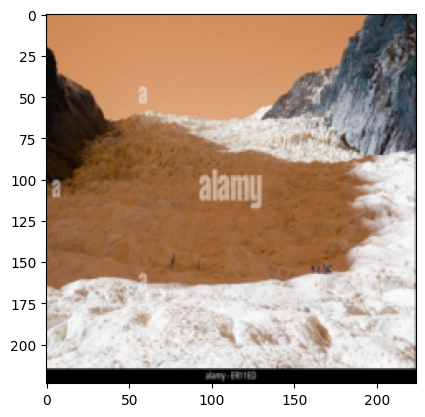

In [44]:
plt.imshow(t[0][0].permute(1,2,0))

In [45]:
pretrained_vit.heads = nn.Linear(in_features=768, out_features=2*768).to(device)

In [46]:
class MultiModalProjector(nn.Module):
    def __init__(self, text_embed_dim, image_embed_dim, dropout=0.1):
        super().__init__()

        # Define the projection network
        self.net = nn.Sequential(
            # Linear layer to expand the image embedding dimension
            nn.Linear(image_embed_dim, 4 * image_embed_dim),

            # GELU activation function
            nn.GELU(),

            # Linear layer to project the expanded image embeddings to the text embedding dimension
            nn.Linear(4 * image_embed_dim, text_embed_dim),

            # Dropout layer for regularization
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Pass the input through the projection network
        x = self.net(x)
        return x

##### Work on the text part

In [47]:
# from transformers import AutoTokenizer

In [48]:
# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [49]:
# def encode(batch_text):
#     return [tokenizer.encode(i) for i in batch_text]

# def decode(batch_tokens):
#     return [tokenizer.decode(i) for i in batch_tokens]

In [50]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


class Head_txt(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        #https://stackoverflow.com/questions/57540745/what-is-the-difference-between-register-parameter-and-register-buffer-in-pytorch
        self.register_buffer('tril', torch.tril(torch.ones(block_size+1, block_size+1)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        #print("**",wei)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention_txt(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head_txt(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward_txt(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block_txt(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention_txt(n_head, head_size)
        self.ffwd = FeedFoward_txt(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x)) # residual connection
        x = x + self.ffwd(self.ln2(x)) # residual connection
        return x

In [51]:
# super simple bigram model
class DecoderOnlyLanguageModel(nn.Module):

    def __init__(self, img_embed_dim):
        super().__init__()
        #--------------------------------------------------#
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd) #** Learnable Token Embedding
        
        self.image_embed_projector = MultiModalProjector(n_embd, img_embed_dim)
        
        self.position_embedding_table = nn.Embedding(block_size+1, n_embd) #** Learnable Positional Encoding
        #--------------------------------------------------#
        
        #-------------- Enters the transformer block ------#
        #self.sa_head = MultiHeadAttention(n_head, n_embd//4) #Head(n_embd)
        #self.ff = FeedFoward(n_embd)
        self.blocks = nn.Sequential(*[Block_txt(n_embd, n_head=n_head) for _ in range(n_blocks)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)
        #--------------------------------------------------#

    def forward(self, idx, image_embeds=None, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        
        img_proj_embed = self.image_embed_projector(image_embeds).unsqueeze(1)
        tok_emb = torch.cat([tok_emb, img_proj_embed], dim =1)
        
        pos_emb = self.position_embedding_table(torch.arange(tok_emb.size(1), device=device)).unsqueeze(0)

        x = tok_emb + pos_emb # (B,T,C)
        #x = self.ln_f(x)
        #x = self.sa_head(x)
        #x = self.ff(x)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        
        #### No Softmax needed as cross_entropy function in pytorch internally applies
        #### the softmax before loss calculation
        
        if targets is not None:
            batch_size = idx.size(0)
            targets = torch.cat([torch.full((batch_size, 1), -100, dtype=torch.long, device=device), targets], dim=1)
                        
            # Compute the cross-entropy loss
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-100)
            return logits, loss

        return logits

    def generate(self, idx, image_embeds, max_new_tokens, top_k=0, top_p=0.):
        # idx is (B, T) array of indices in the current context
        B, T = idx.shape

        # Initialize the generated sequence with the input indices
        generated = idx

        img_emb = self.image_embed_projector(image_embeds).unsqueeze(1)
        current_output = torch.cat([img_emb, self.token_embedding_table(idx)], dim=1)

        # Generate new tokens iteratively
        for i in range(max_new_tokens):
            # Get the current sequence length
            T_current = current_output.size(1)

            # Get position embeddings for the current sequence length
            current_pos_emb = self.position_embedding_table(torch.arange(T_current, device=device)).unsqueeze(0)

            # Add position embeddings to the current output
            current_output += current_pos_emb
            
            #print("current_output shape", current_output.shape)
            # Pass through the transformer decoder blocks
            
            current_output = self.blocks(current_output)

            # Get the logits for the last token
            logits = self.lm_head(current_output[:, -1, :])
            
            # Filter logits using top_k and/or top_p
            logits = self._filter_logits(logits, top_k=top_k, top_p=top_p)

            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample the next token based on the probabilities
            idx_next = torch.multinomial(probs, num_samples=1)

            # Concatenate the generated token to the generated sequence
            generated = torch.cat((generated, idx_next), dim=1)

            # Get the embeddings for the generated token
            idx_next_emb = self.token_embedding_table(idx_next)

            # Concatenate the generated token embeddings to the current output
            current_output = torch.cat((current_output, idx_next_emb), dim=1)

        return generated
    
    
    def _filter_logits(self, logits, top_k=0, top_p=0.0):
        top_k = min(top_k, logits.size(-1))  # safety

        if top_k > 0:
            values, _ = torch.topk(logits, top_k)
            min_values = values[:, -1, None]
            logits = torch.where(logits < min_values, torch.full_like(logits, float('-inf')), logits)

        if top_p > 0.0:
            sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

            sorted_mask = cumulative_probs > top_p
            sorted_mask[:, 1:] = sorted_mask[:, :-1].clone()
            sorted_mask[:, 0] = False

            indices_to_remove = sorted_mask.scatter(1, sorted_indices, sorted_mask)
            logits = logits.masked_fill(indices_to_remove, float('-inf'))

        return logits

In [52]:
# batch_size= 16
block_size= 50
max_iters= 3000
eval_interval= 100
# learning_rate= 0.0001
eval_iters= 200
n_embd= 512
n_head= 4
n_blocks= 8
dropout= 0.2

In [53]:
vocab_size = tokenizer.get_vocab_size()

In [54]:
vocab_size

4600

In [55]:
class VisionLanguageModel(nn.Module):
    def __init__(self, image_embed_dim, num_heads):
        super().__init__()

        # Set num_hiddens equal to image_embed_dim
        num_hiddens = image_embed_dim

        # Assert that num_hiddens is divisible by num_heads
        assert num_hiddens % num_heads == 0, "num_hiddens must be divisible by num_heads"

        # Initialize the vision encoder (ViT)
        self.vision_encoder = pretrained_vit

        # Initialize the language model decoder (DecoderLanguageModel)
        self.decoder = DecoderOnlyLanguageModel(image_embed_dim)

    def forward(self, img_array, idx, targets=None):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)

        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")

        if targets is not None:
            # If targets are provided, compute the logits and loss
            logits, loss = self.decoder(idx, image_embeds, targets)
            return logits, loss
        else:
            # If targets are not provided, compute only the logits
            logits = self.decoder(idx, image_embeds)
            return logits

    def generate(self, img_array, idx, max_new_tokens, top_p=0.0, top_k=0.0):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)

        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")

        # Generate new tokens using the language model decoder
        generated_tokens = self.decoder.generate(idx, image_embeds, max_new_tokens, top_k=top_k, top_p=top_p)
        return generated_tokens

In [56]:
vlm = VisionLanguageModel(image_embed_dim=2*768, num_heads=n_head).to(device)

The **maximum context length** should be **≤ `block_size`** in your model because:

1. **Batch Construction in `get_batch`**  
   - `block_size` determines how many tokens each input (`x`) and target (`y`) will have.  
   - The function slices `block_size` tokens from `data[i:i+block_size]` for `x`, meaning that each training example has `block_size` tokens.  

2. **Self-Attention Masking in `Head_txt`**  
   - The `tril` mask (`torch.tril(torch.ones(block_size, block_size))`) ensures that tokens only attend to previous or current tokens within a **window of size `block_size`**.  
   - If your context length exceeded `block_size`, attention calculations wouldn’t handle dependencies beyond `block_size`.

### **What Happens If Context Length > `block_size`?**  
- The model wouldn’t be able to process longer sequences correctly because the mask only supports up to `block_size`.  
- Inputs longer than `block_size` would be **truncated** or need to be processed in overlapping chunks.  

### **Conclusion**
Your **effective context window is at most `block_size`**, ensuring attention and training dynamics remain consistent. If you need longer context, increase `block_size`, but this also increases memory and compute costs.

In [57]:
def get_batch(image_tokens, caps, block_size):
    all_inputs = []
    all_targets = []
    all_image_tokens = []

    for j, caption in enumerate(caps):
        tokens = torch.tensor(tokenizer.encode(caption).ids, dtype=torch.long)
        tokens = tokens[:block_size]  # truncate if needed
        for k in range(1, len(tokens)-1):
            inp = tokens[k:k+block_size]
            tgt = tokens[k+1:k+block_size+1]
            all_inputs.append(inp)
            all_targets.append(tgt)
            all_image_tokens.append(image_tokens[j])  # repeat corresponding image

    # Padding
    max_len = max(len(seq) for seq in all_inputs)
    padded_inputs = torch.full((len(all_inputs), max_len), 0, dtype=torch.long).to(device)
    padded_targets = torch.full((len(all_targets), max_len), 0, dtype=torch.long).to(device)
    image_tokens_expanded = torch.stack(all_image_tokens).to(device)

    for i in range(len(all_inputs)):
        padded_inputs[i, :len(all_inputs[i])] = all_inputs[i]
        padded_targets[i, :len(all_targets[i])] = all_targets[i]
    return image_tokens_expanded, padded_inputs, padded_targets

In [58]:
epochs = 9
train_losses = []
valid_losses = []
test_accuracies = []
best_val_loss = 1e9

In [59]:
wandb.init(
    project="vision-language-model-image-caption",
    config={
        "epochs": 9,
        "batch_size": 128,
        "lr": 3e-4 / 25,
        })

wandb: Currently logged in as: amrkmrc (amrkmrc-capgemini). Use `wandb login --relogin` to force relogin


In [60]:
config = wandb.config

In [61]:
config

{'epochs': 9, 'batch_size': 128, 'lr': 1.1999999999999999e-05}

In [62]:
optim = torch.optim.Adam(vlm.parameters(),lr=config.lr, weight_decay=1e-3) #lr = 6e-4 / 25.
sched = torch.optim.lr_scheduler.OneCycleLR(optim,max_lr=1e-4 ,steps_per_epoch=len(train_dl),epochs=epochs)

In [63]:
for ep in tqdm(range(config.epochs)):
    vlm.train()
    trl = 0.
    tprog = tqdm(enumerate(train_dl), total=len(train_dl))

    for i, (image_tokens, caps) in tprog:
        image_tokens = image_tokens.to(device)
        
        image_tokens_expanded, padded_inputs, padded_targets = get_batch(image_tokens, caps, block_size)

        # Forward & backward pass
        loss = vlm(image_tokens_expanded, padded_inputs, padded_targets)[1]
        loss.backward()
        optim.step()
        optim.zero_grad()
        sched.step()
        trl += loss.item()
        tprog.set_description(f'train step loss: {loss.item():.4f}')
    train_losses.append(trl / len(train_dl))

    # Validation loop (same logic)
    vlm.eval()
    with torch.no_grad():
        vrl = 0.
        vprog = tqdm(enumerate(val_dl), total=len(val_dl))
        for i, (image_tokens, caps) in vprog:
            image_tokens = image_tokens.to(device)

            image_tokens_expanded, padded_inputs, padded_targets = get_batch(image_tokens, caps, block_size)

            loss = vlm(image_tokens_expanded, padded_inputs, padded_targets)[1]
            vrl += loss.item()
            vprog.set_description(f'valid step loss: {loss.item():.4f}')
        vloss = vrl / len(val_dl)
        valid_losses.append(vloss)
        print(f'epoch {ep} | train_loss: {train_losses[-1]:.4f} valid_loss: {valid_losses[-1]:.4f}')
    wandb.log({"train_loss": train_losses[-1], "valid_loss": valid_losses[-1]})
wandb.finish()

train step loss: 3.0355:  16%|██▋              | 61/388 [00:30<02:41,  2.02it/s]Premature end of JPEG file

train step loss: 2.9019:  25%|████▏            | 96/388 [00:47<02:29,  1.96it/s]


train step loss: 2.1455:  50%|███████▉        | 193/388 [01:38<01:53,  1.71it/s]


train step loss: 1.5758:  75%|███████████▉    | 290/388 [02:35<01:00,  1.61it/s]


train step loss: 1.3302: 100%|███████████████▉| 387/388 [03:36<00:00,  1.28it/s]


train step loss: 1.8449: 100%|████████████████| 388/388 [03:36<00:00,  1.79it/s]

 11%|████▉                                       | 1/9 [04:13<33:51, 253.99s/it]

epoch 0 | train_loss: 2.6890 valid_loss: 1.6106



train step loss: 1.5465:   6%|█                | 24/388 [00:26<06:52,  1.13s/it]Premature end of JPEG file

train step loss: 1.2683:  25%|████▏            | 96/388 [01:57<03:56,  1.24it/s]


train step loss: 1.1113:  50%|███████▉        | 193/388 [03:35<03:15,  1.00s/it]


train step loss: 0.9657:  75%|███████████▉    | 290/388 [05:42<02:06,  1.29s/it]


train step loss: 1.2679: 100%|███████████████▉| 387/388 [08:12<00:01,  1.52s/it]


train step loss: 1.2679: 100%|████████████████| 388/388 [08:12<00:00,  1.27s/it]

 22%|█████████▊                                  | 2/9 [13:39<51:00, 437.18s/it]

epoch 1 | train_loss: 1.1605 valid_loss: 0.8467



train step loss: 0.7921:  16%|██▊              | 64/388 [02:20<08:48,  1.63s/it]Premature end of JPEG file

train step loss: 0.8647:  25%|████▏            | 96/388 [03:13<09:23,  1.93s/it]


train step loss: 0.5754:  50%|███████▉        | 193/388 [06:18<03:19,  1.03s/it]


train step loss: 0.3832:  75%|███████████▉    | 290/388 [08:41<02:35,  1.59s/it]


train step loss: 0.6414: 100%|███████████████▉| 387/388 [10:46<00:01,  1.08s/it]


train step loss: 0.6414: 100%|████████████████| 388/388 [10:46<00:00,  1.67s/it]

 33%|██████████████▋                             | 3/9 [25:17<55:37, 556.17s/it]

epoch 2 | train_loss: 0.6559 valid_loss: 0.5607



train step loss: 0.4637:  25%|████▏            | 96/388 [01:55<04:57,  1.02s/it]


train step loss: 0.5965:  50%|███████▉        | 193/388 [03:35<03:17,  1.01s/it]


train step loss: 0.4373:  75%|███████████▉    | 290/388 [05:22<02:33,  1.57s/it]Premature end of JPEG file

train step loss: 0.4269:  75%|███████████▉    | 290/388 [05:23<02:33,  1.57s/it]


train step loss: 0.3875: 100%|███████████████▉| 387/388 [07:27<00:01,  1.08s/it]


train step loss: 0.3875: 100%|████████████████| 388/388 [07:27<00:00,  1.15s/it]

 44%|███████████████████▌                        | 4/9 [33:22<44:00, 528.10s/it]

epoch 3 | train_loss: 0.4618 valid_loss: 0.4479



train step loss: 0.2922:  25%|████▏            | 96/388 [02:14<09:27,  1.94s/it]


train step loss: 0.3217:  50%|███████▉        | 193/388 [04:33<03:41,  1.14s/it]


train step loss: 0.2775:  75%|███████████▉    | 290/388 [06:55<02:07,  1.30s/it]


train step loss: 0.4519:  82%|█████████████   | 318/388 [07:22<01:02,  1.11it/s]Premature end of JPEG file

train step loss: 0.3359: 100%|███████████████▉| 387/388 [08:24<00:01,  1.02s/it]


train step loss: 0.3359: 100%|████████████████| 388/388 [08:24<00:00,  1.30s/it]

 56%|████████████████████████▍                   | 5/9 [42:18<35:24, 531.11s/it]

epoch 4 | train_loss: 0.3717 valid_loss: 0.3934



train step loss: 0.3023:  25%|████▏            | 96/388 [01:23<03:58,  1.22it/s]


train step loss: 0.4106:  34%|█████▍          | 132/388 [02:01<05:48,  1.36s/it]Premature end of JPEG file

train step loss: 0.2908:  50%|███████▉        | 193/388 [03:16<05:49,  1.79s/it]


train step loss: 0.3945:  75%|███████████▉    | 290/388 [05:01<01:44,  1.07s/it]


train step loss: 0.3857: 100%|███████████████▉| 387/388 [06:20<00:00,  1.31it/s]


train step loss: 0.3857: 100%|████████████████| 388/388 [06:20<00:00,  1.02it/s]

 67%|█████████████████████████████▎              | 6/9 [49:07<24:28, 489.42s/it]

epoch 5 | train_loss: 0.3263 valid_loss: 0.3669



train step loss: 0.3244:  20%|███▎             | 76/388 [00:57<03:51,  1.35it/s]Premature end of JPEG file

train step loss: 0.4123:  25%|████▏            | 96/388 [01:15<03:47,  1.28it/s]


train step loss: 0.3317:  50%|███████▉        | 193/388 [02:27<02:20,  1.39it/s]


train step loss: 0.4368:  75%|███████████▉    | 290/388 [03:41<01:15,  1.30it/s]


train step loss: 0.2591: 100%|███████████████▉| 387/388 [04:53<00:00,  1.32it/s]


train step loss: 0.2591: 100%|████████████████| 388/388 [04:53<00:00,  1.32it/s]

 78%|██████████████████████████████████▏         | 7/9 [54:28<14:28, 434.46s/it]

epoch 6 | train_loss: 0.2987 valid_loss: 0.3527



train step loss: 0.2272:  25%|████▏            | 96/388 [01:16<03:42,  1.31it/s]


train step loss: 0.1503:  50%|███████▉        | 193/388 [02:27<02:12,  1.47it/s]


train step loss: 0.3740:  74%|███████████▉    | 289/388 [03:39<01:10,  1.41it/s]Premature end of JPEG file

train step loss: 0.3722:  75%|███████████▉    | 290/388 [03:40<01:03,  1.54it/s]


train step loss: 0.2753: 100%|███████████████▉| 387/388 [04:56<00:00,  1.25it/s]


train step loss: 0.2753: 100%|████████████████| 388/388 [04:56<00:00,  1.31it/s]

 89%|███████████████████████████████████████     | 8/9 [59:53<06:39, 399.73s/it]

epoch 7 | train_loss: 0.2847 valid_loss: 0.3480



train step loss: 0.1753:  25%|████▏            | 96/388 [01:18<03:38,  1.33it/s]


train step loss: 0.2214:  50%|███████▉        | 193/388 [02:34<02:46,  1.17it/s]


 89%|█████████████████████████████████████▎    | 8/9 [1:02:52<07:51, 471.57s/it]


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [59]:
sd = vlm.state_dict()
torch.save(sd,'vlm-epoch5/model-11-04-2025.pt')

In [60]:
torch.cuda.empty_cache()

In [61]:
dummy_idx = torch.randint(0, vocab_size, (10, 1)).to(device)

In [72]:
start_token = tokenizer.encode("[START]").ids
start = torch.tensor(start_token, dtype=torch.long).unsqueeze(0).repeat(10, 1).to(device)

In [73]:
t = next(iter(val_dl))

In [74]:
import gc
torch.cuda.empty_cache()
gc.collect()

3887

In [97]:
gen = vlm.generate(t[0].to(device), start, 15, top_p=0.8, top_k=2000)

In [98]:
gen

tensor([[   2, 1317, 1317, 1317, 2669, 4103, 3982,  357,  357,  357,  869,  869,
         3981, 2385, 4282, 3618],
        [   2, 3893, 3766, 4061, 1236,  911,  911, 3633, 4485,  774,  213,  112,
          112, 4314, 1483, 4341],
        [   2, 3638, 3087, 2462, 4544, 3249, 4274, 2093, 2093, 2093, 2286, 2296,
         3234,  534,  445,  445],
        [   2, 2451, 1230, 3922, 4573, 1584, 2472, 2447, 3867,  318, 2498, 4062,
         2744, 1317, 1317,  118],
        [   2, 2080, 1380, 4054, 1358, 2183, 2430, 2430, 4074, 3290, 1754,  413,
         3264, 3883, 1862,   38],
        [   2, 1512, 3673,  440, 4117, 3211, 2181, 1543,  769, 3892, 1305, 4042,
          741,  741,  476, 2253],
        [   2,  416, 3394, 2791, 2282, 1473, 2201, 1522, 1522, 1030, 2326, 2093,
         2093, 1702,  675, 1356],
        [   2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [   2, 3133, 3999, 3129, 1811, 3379, 3863, 4052, 3016, 2619,  791, 2683,

generated:  

actual:  [START] bride and her father sharing a dance at her wedding . [END]


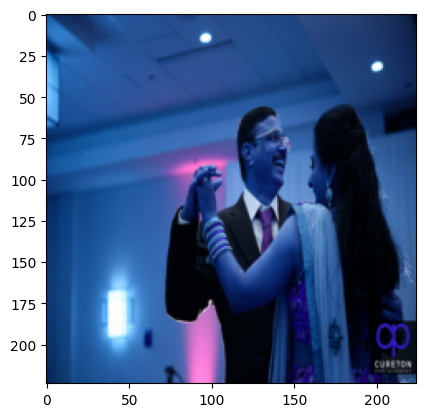

In [100]:
j = 9
plt.imshow(t[0][j].permute(1,2,0))
print("generated: ", tokenizer.decode(gen[j].detach().cpu().tolist()))
print("\nactual: ", t[1][j])

In [80]:
# gen_text = gen.detach().cpu()
# gen_text[].tolist()
# # decode(gen.detach().cpu()[3])

In [81]:
# tokenizer.decode(gen[3])

In [48]:
vlm.load_state_dict(torch.load("vlm-epoch5/model-10-04-2025.pt"))

<All keys matched successfully>

In [64]:
import datasets
ds = datasets.load_dataset("ydshieh/coco_dataset_script", "2017", data_dir="./dummy_data/")

README.md:   0%|          | 0.00/781 [00:00<?, ?B/s]

coco_dataset_script.py:   0%|          | 0.00/8.43k [00:00<?, ?B/s]

The repository for ydshieh/coco_dataset_script contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ydshieh/coco_dataset_script.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Repo card metadata block was not found. Setting CardData to empty.


train2017.zip:   0%|          | 0.00/3.59M [00:00<?, ?B/s]

val2017.zip:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

test2017.zip:   0%|          | 0.00/3.02M [00:00<?, ?B/s]

annotations_trainval2017.zip:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

image_info_test2017.zip:   0%|          | 0.00/3.68k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [68]:
len(ds["train"])

80